In [1]:
import scanpy as sc
import anndata as ad
import numpy as np

# 1. Load generated data

In [2]:
d1 = ad.read_h5ad('data/dataseta0.h5ad')
d2 = ad.read_h5ad('data/datasetb0.h5ad')

d1.uns["iroot"] = np.flatnonzero(d1.obs_names == d1.uns["iroot"])[0]
d2.uns["iroot"] = np.flatnonzero(d2.obs_names == d2.uns["iroot"])[0]

In [3]:
# Construct cutoff branch
d2 = d2[d2.obs["milestones"] != "sEndC", :]
d2.write_h5ad("data/datasetb0_cut.h5ad")

In [4]:
def preprocess(dataset):
    sc.pp.normalize_total(dataset, target_sum=1e4)
    sc.pp.log1p(dataset)
    sc.pp.pca(dataset)
    sc.pp.neighbors(dataset, n_neighbors=10)
    sc.tl.umap(dataset)
    sc.tl.leiden(dataset)
    return dataset

# Preprocess data

## Preprocess d1

In [5]:
d1 = preprocess(d1)

/tmp/ipykernel_300173/3540951030.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(dataset)


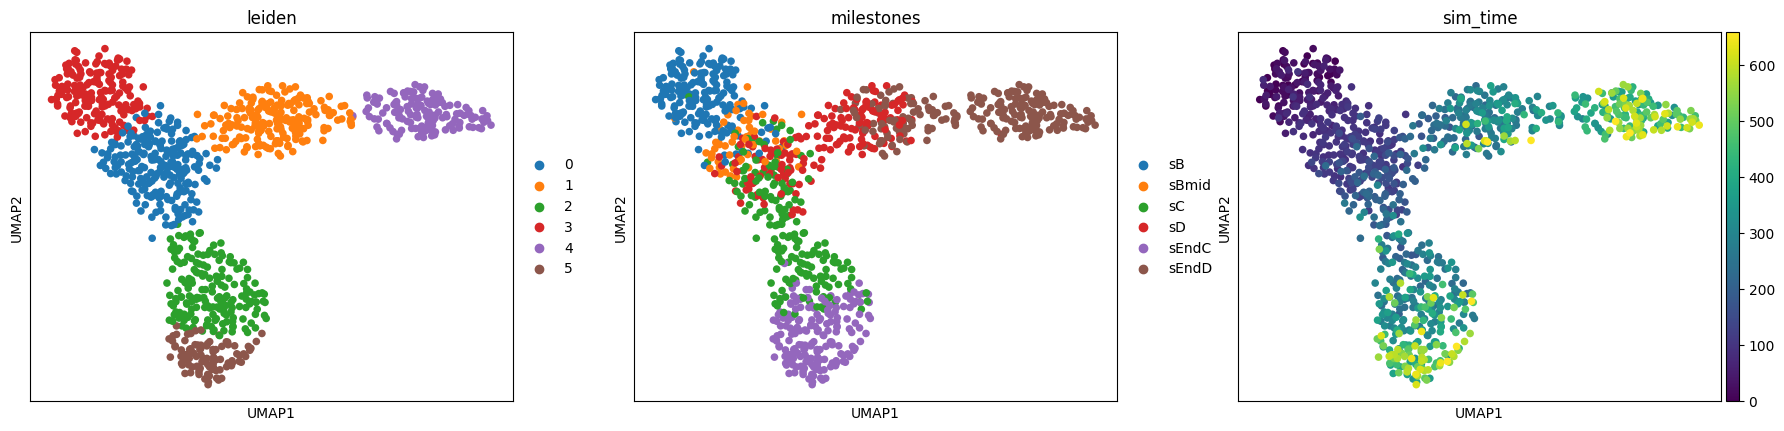

In [6]:
sc.pl.umap(d1, color=["leiden", "milestones", "sim_time"])

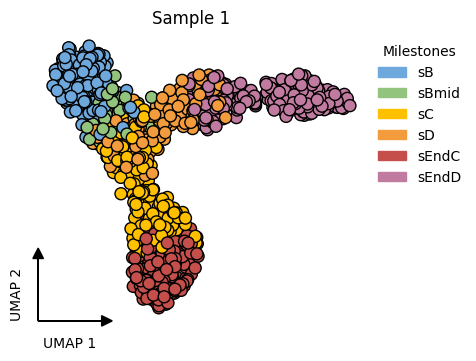

In [36]:
import matplotlib.pyplot as plt

xs = d1.obsm['X_umap'][:, 0]
ys = d1.obsm['X_umap'][:, 1]
labels = d1.obs['milestones'].values
# colors to numbers
colors = ['#6fa8dc','#93c47d','#ffc000','#f39c3d','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
translated_colors = np.array([color_map[c] for c in labels])

# print(translated_colors)

fig, ax = plt.subplots(figsize=(4.5, 4))
ax.scatter(xs, ys, c=translated_colors,  s=75, edgecolors = 'k')

ax.set_title("Sample 1")

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# ax.set_xlabel("Flat tree plot")
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_label_coords(0.25, 0.95)
ax.set_ylabel("")
# plot colormap as a legend
handles = [plt.Circle((0, 0), radius=1, color=c) for c in color_map.values()]
labels = list(color_map.keys())
ax.legend(handles=handles, labels=labels, title="Milestones", loc='best', bbox_to_anchor=(1, 1), frameon=False)

# plot two arrows
x0 = ax.get_xlim()[0]
y0 = ax.get_ylim()[0]

ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
ax.set_xlabel("UMAP 1")
ax.xaxis.set_label_coords(0.15, 0.01)

ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
ax.set_ylabel("UMAP 2")
ax.yaxis.set_label_coords(0.02, 0.15)

In [7]:
# ensure that these are the leiden clusters corresponding to the milestones "sB", "sEndC", "sEndD"
d1.uns["slingshot_start"] = ["3"]
d1.uns["slingshot_end"] = ["4", "5"]

In [8]:
d1.write_h5ad("data/dataseta0_processed.h5ad")

## Preprocess d2

In [37]:
d2 = preprocess(d2)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


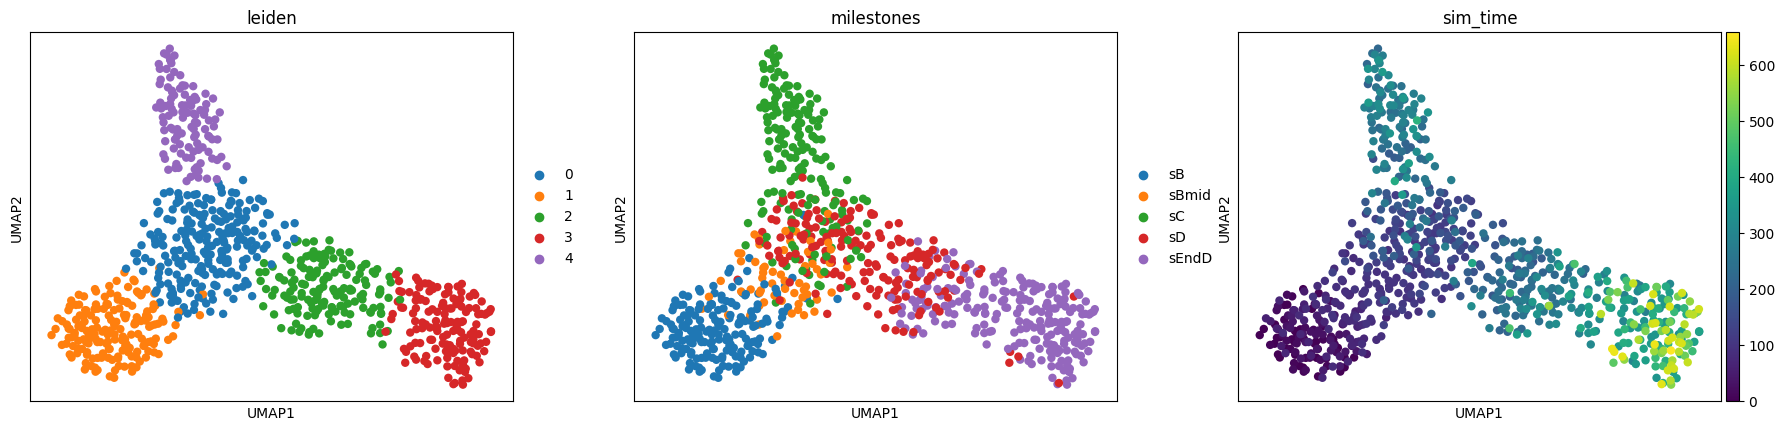

In [38]:
sc.pl.umap(d2, color=["leiden", "milestones", "sim_time"])

In [39]:
# ensure that these are the leiden clusters corresponding to the milestones "sB", "sC", "sEndD"
d2.uns["slingshot_start"] = ["1"]
d2.uns["slingshot_end"] = ["3", "4"]

In [62]:
def plot_dataset(d1, title, ax, color_map, legend_ax = None, dimred = "X_umap", colorlabel = "milestones"):
    xs = d1.obsm[dimred][:, 0]
    ys = d1.obsm[dimred][:, 1]
    labels = d1.obs[colorlabel].values
    # colors to numbers
    colors = ['#6fa8dc','#93c47d','#ffc000','#f39c3d','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

    # color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    ax.scatter(xs, ys, c=translated_colors,  s=50, edgecolors = 'k')

    ax.set_title(title)

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.25, 0.95)
    ax.set_ylabel("")
    
    if legend_ax is not None:
        # plot colormap as a legend in a separate axis
        handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in color_map.values()]
        labels = list(color_map.keys())
        legend_ax.legend(handles=handles, labels=labels, title=colorlabel.capitalize(), loc='best', bbox_to_anchor=(1, 1), frameon=False)
        legend_ax.axis('off')

    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_xlabel("UMAP 1")
    ax.xaxis.set_label_coords(0.15, 0.01)

    ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_ylabel("UMAP 2")
    ax.yaxis.set_label_coords(0.02, 0.15)

    return fig, ax

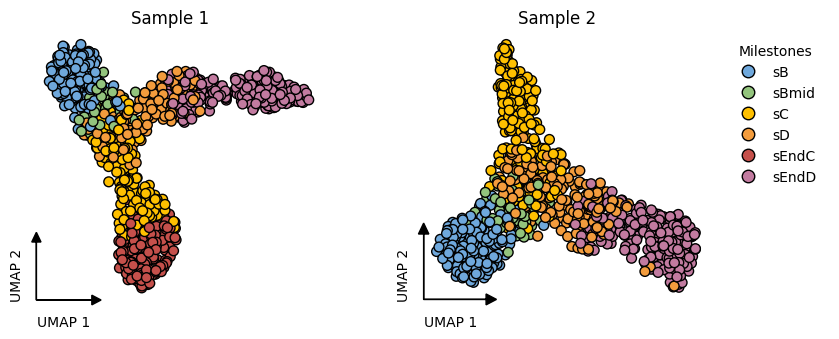

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(8.5, 3.5), width_ratios=[4, 4, 0.5])

color_map = {label: colors[i] for i, label in enumerate(np.unique(d1.obs['milestones']))}
translated_colors = np.array([color_map[c] for c in d1.obs['milestones']])

plot_dataset(d1, "Sample 1", axes[0], color_map, legend_ax=axes[2])
plot_dataset(d2, "Sample 2", axes[1], color_map)

plt.tight_layout()
plt.savefig("figures/2_preprocess_umap.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_preprocess_umap.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

xs = d1.obsm['X_umap'][:, 0]
ys = d1.obsm['X_umap'][:, 1]
labels = d1.obs['milestones'].values
# colors to numbers
colors = ['#6fa8dc','#93c47d','#ffc000','#f39c3d','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
translated_colors = np.array([color_map[c] for c in labels])

# print(translated_colors)

fig, ax = plt.subplots(figsize=(4.5, 4))
ax.scatter(xs, ys, c=translated_colors,  s=75, edgecolors = 'k')

ax.set_title("Sample 1")

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# ax.set_xlabel("Flat tree plot")
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_label_coords(0.25, 0.95)
ax.set_ylabel("")
# plot colormap as a legend
handles = [plt.Circle((0, 0), radius=1, color=c) for c in color_map.values()]
labels = list(color_map.keys())
ax.legend(handles=handles, labels=labels, title="Milestones", loc='best', bbox_to_anchor=(1, 1), frameon=False)

# plot two arrows
x0 = ax.get_xlim()[0]
y0 = ax.get_ylim()[0]

ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
ax.set_xlabel("UMAP 1")
ax.xaxis.set_label_coords(0.15, 0.01)

ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
ax.set_ylabel("UMAP 2")
ax.yaxis.set_label_coords(0.02, 0.15)

In [40]:
d2.write_h5ad("data/datasetb0_processed.h5ad")

Continue with slingshot.R

# Select pseudotime

In [13]:
d1 = ad.read_h5ad("data/dataset1_slingshot.h5ad")
d2 = ad.read_h5ad("data/dataset2_slingshot.h5ad")

d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

In [14]:
d1, d2

(AnnData object with n_obs × n_vars = 1000 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'slingPseudotime_1', 'slingPseudotime_2'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'leiden', 'leiden_colors', 'log1p', 'milestones_colors', 'neighbors', 'pca', 'slingshot_end', 'slingshot_start', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'umap'
     obsm: 'X_pca', 'X_umap', 'dimred'
     layers: 'X', 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 822 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'slingPseudotime_1', 'slingPseudotim

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


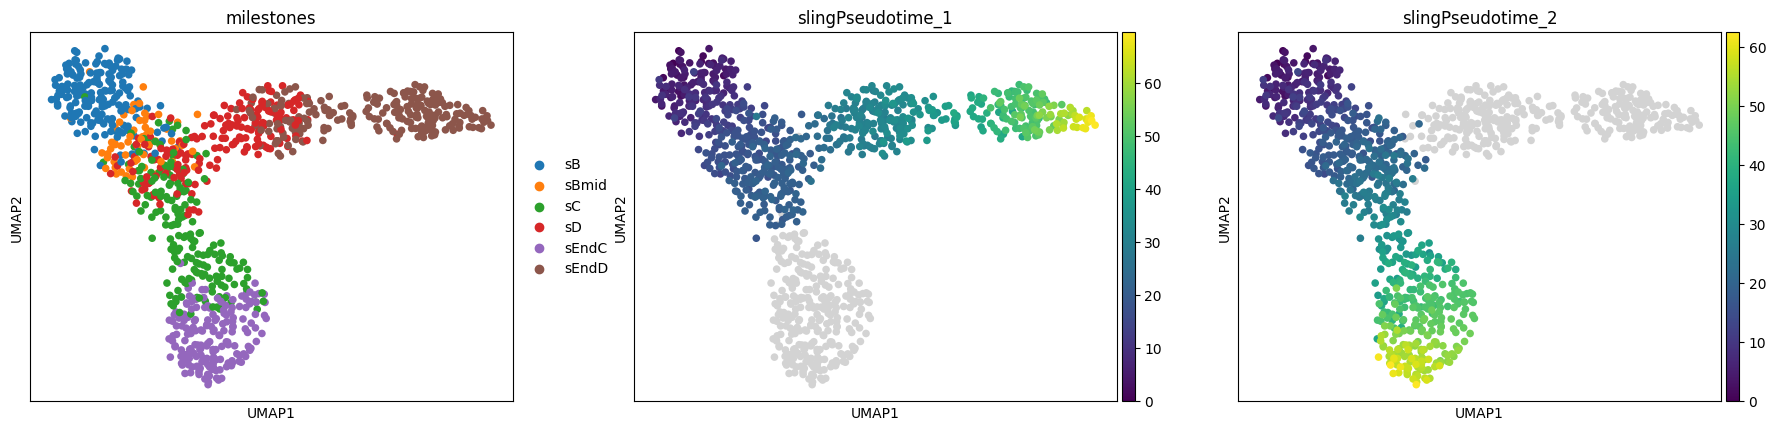

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


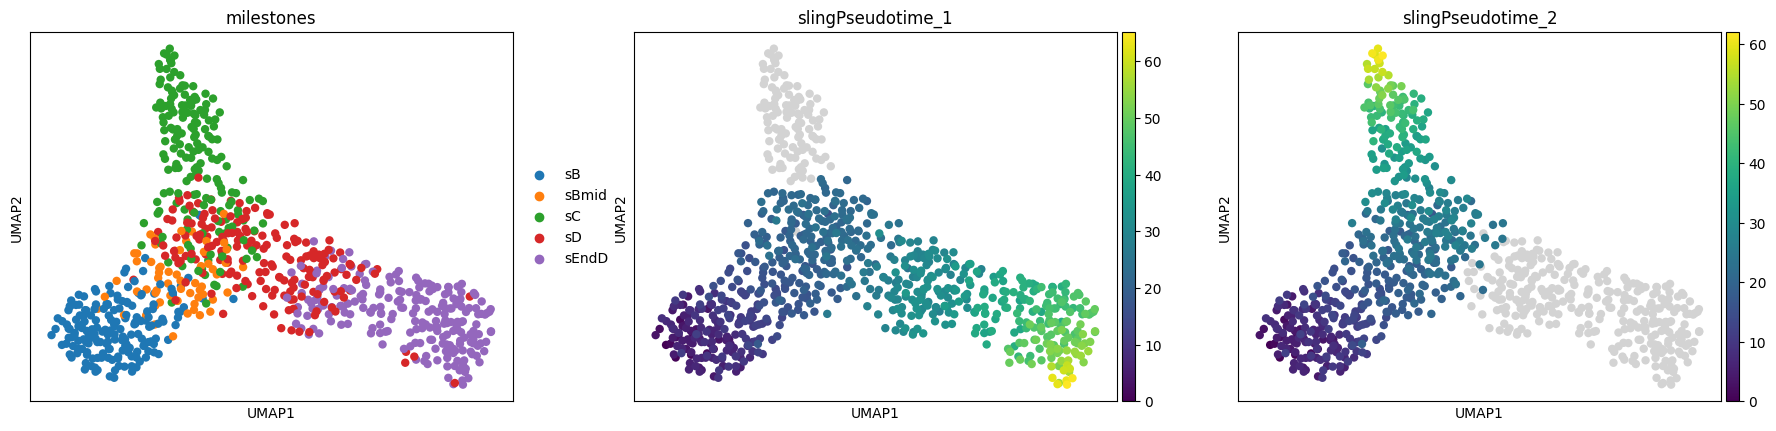

In [15]:
sc.pl.umap(d1, color=["milestones", "slingPseudotime_1", "slingPseudotime_2"])
sc.pl.umap(d2, color=["milestones", "slingPseudotime_1", "slingPseudotime_2"])

In [16]:
# select all cells in slingPseudotime_1 and assign them to linD "TRUE" in obs
d1.obs["linD"] = d1.obs["slingPseudotime_1"].apply(lambda x: "TRUE" if not np.isnan(x) else "FALSE")
d2.obs["linD"] = d2.obs["slingPseudotime_1"].apply(lambda x: "TRUE" if not np.isnan(x) else "FALSE")

# select all cells in slingPseudotime_2 and assign them to linC "TRUE" in obs
d1.obs["linC"] = d1.obs["slingPseudotime_2"].apply(lambda x: "TRUE" if not np.isnan(x) else "FALSE")
d2.obs["linC"] = d2.obs["slingPseudotime_2"].apply(lambda x: "TRUE" if not np.isnan(x) else "FALSE")

# rename slingPseudotime_1 to orig_linD_pseudotime
d1.obs.rename(columns={"slingPseudotime_1": "orig_linD_pseudotime"}, inplace=True)
d2.obs.rename(columns={"slingPseudotime_1": "orig_linD_pseudotime"}, inplace=True)

# rename slingPseudotime_2 to orig_linC_pseudotime
d1.obs.rename(columns={"slingPseudotime_2": "orig_linC_pseudotime"}, inplace=True)
d2.obs.rename(columns={"slingPseudotime_2": "orig_linC_pseudotime"}, inplace=True)

d1.obs, d2.obs

(          step_ix  simulation_i    sim_time milestones leiden  \
 cell1        4972            62  150.083333         sD      0   
 cell2        7919            98  460.083333         sD      4   
 cell3          54             1  380.083333      sEndD      4   
 cell4        2870            36  190.000000         sD      0   
 cell5        4848            60  530.083333      sEndC      5   
 ...           ...           ...         ...        ...    ...   
 cell996      5932            74   30.083333         sB      3   
 cell997       285             4  260.000000      sEndC      2   
 cell998      2154            27  320.083333         sC      2   
 cell999      6114            76  230.000000         sD      1   
 cell1000     2533            32   60.000000         sB      3   
 
           orig_linD_pseudotime  orig_linC_pseudotime   linD   linC  
 cell1                23.534008             23.849089   TRUE   TRUE  
 cell2                42.164078                   NaN   TRUE  FALS

In [17]:
d1.write_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2.write_h5ad("data/dynchro2_slingshot_processed.h5ad")